# SML 312
### Final Project - JWST Exoplanet Transit Detection
### Jackie Liu (jl1536)

**Objective**: Use time series flux data from star emissions at different wavelengths from JWST to predict existence of exoplanets (seems simple enough... right?)

# 0.1 Imports and Whatnot

Always important to do.

**Note**: Need to mount Google Drive (and be me because the filepaths are hardcoded but that's a different story)

In [1]:
!pip install astropy

import numpy as np
import matplotlib.pyplot as plt
import astropy as ap
from astropy.io import fits
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.9 MB/s eta 0:00:00
Mounted at /content/drive


# 0.2 Generating Training Data

Turns out that getting good data is actually really hard. We'll need to generate some synthetic data as per the other paper.

The instrument sampled uses wavelengths from 2.4 um to 4.4 um approximately according to the data and generally records information in the 0.5 - 5.0 um low infrared range.

The rest of the training parameters will be generally borrowed from the paper, with some adjustments made to account for different normalization.

The normalized transit function is given below:

$c_0 + c_1 + c_2 + c_3 + c_4 = 1$

$i(x) = 1 - \sum_1^4 c_n(1-cos(x)^{n/2})$

$I_1(x) = \frac{1}{4xp}\int_{x-p}^{x+p}2ri(r)dr$

$I_2(x) = \frac{1}{1-(x-p)^2}\int_{x-p}^12ri(r)dr$

$F_1(x) = 1 - \frac{p^2}{4G}I_1(x)$

$F_2(x) = 1 - \frac{I_2(x)}{4\pi G}(p^2 \arccos(\frac{x-1}{p}) - (x-1)\sqrt{p^2 - (x-1)^2}))$

$F_3(x) = F_2(-x)$

$F_{transit}(x) = \begin{cases} F_3(x) & x \in [-1, -1 + p) \\ F_1(x) & x \in [-1 + p, 1 - p] \\ F_2(x) & x \in (1 - p, 1]  \end{cases}$

$A(t) = A (1 + \sin \left(\frac{2\pi (t - t')}{P_A}\right))$

$\omega(t) = \omega (1 + \sin \left(\frac{2\pi (t - t')}{P_{\omega}}\right))$


$F_{final}(x) = F_{transit}(x) * N(1, \frac{p^2}{\sigma_{tot}}) * (1 + A(t) \sin \left(\frac{2\pi (t - t')}{w(t)} + \phi\right))$

In [2]:
def iii(x, params):
  c = params['c']
  s1 = c[1] * (1 - np.cos(x) ** (1/2))
  s2 = c[2] * (1 - np.cos(x) ** (1))
  s3 = c[3] * (1 - np.cos(x) ** (3/2))
  s4 = c[4] * (1 - np.cos(x) ** (2))

  return 1 - (s1 + s2 + s3 + s4)

def Iint(x, params):
  return 2 * x * iii(x, params)

def Iint_arr(x, p, res, params):
  num_points = int(np.ceil(2 * p / res))
  results = np.zeros_like(x)

  for i, x_val in enumerate(x):
      domain = np.linspace(x_val - p, x_val + p, num_points)
      y = Iint(domain, params)
      results[i] = np.trapz(y, domain)

  return results

def I2int_arr(x, p, res, params):
  results = np.zeros_like(x)

  for i, x_val in enumerate(x):
    num_points = int(np.ceil((1 - x_val + p) / res))

    if num_points > 1:
      domain = np.linspace(x_val - p, 1, num_points)
      y = Iint(domain, params)
      results[i] = np.trapz(y, domain)
    else:
      results[i] = 0

  return results

def I1(x, params):
  c = params['c']
  p = params['p']
  res = params['res']
  coef = 1 / (4 * x * p)
  integ = Iint_arr(x, p, res, params)
  return coef * integ

def I2(x, params):
  c = params['c']
  p = params['p']
  res = params['res']
  coef = 1 / (1 - (x - p) ** 2)
  integ = I2int_arr(x, p, res, params)
  return coef * integ

def F1(x, params):
  p = params['p']
  G = params['G']
  coef = (p ** 2) / (4 * G)
  return 1 - coef * I1(x, params)

def F2(x, params):
  p = params['p']
  G = params['G']
  coef = 1 / (4 * np.pi * G)
  trail = (p ** 2) * np.arccos((x - 1) / p) - (x - 1) * np.sqrt(p ** 2 - (x - 1) ** 2)
  return 1 - coef * I2(x, params) * trail

def F3(x, params):
  return F2(-x, params)

def F(x, params):
  p = params['p']
  return np.piecewise(x, [(-1 <= x) & (x < -1 + p), (-1 + p <= x) & (x <= 1 - p), (1 - p < x) & (x <= 1)], [
      lambda x: F3(x, params), lambda x: F1(x, params), lambda x: F2(x, params)
  ])

def pad(x, params, left, right):
  res = params['res']
  leftarr = np.ones(int(left / res))
  rightarr = np.ones(int(right / res))
  return np.concatenate((leftarr, F(x, params), rightarr))

def A(x, params):
  a = params['a']
  pa = params['pa']
  return a * (1 + np.sin((2 * np.pi / pa) * x))

def W(x, params):
  w = params['w']
  pw = params['pw']
  return w * (1 + np.sin((2 * np.pi / pw) * x))

def fin(x, params, left, right):
  res = params['res']
  p = params['p']
  stot = params['stot']
  phi = params['phi']

  block = int(1 / res)

  out_y = pad(x, params, left, right)

  noise_x = np.linspace(0, out_y.shape[0] / block, out_y.shape[0])
  gauss = np.random.normal(loc=1, scale = p ** 2 / stot, size=noise_x.shape)
  a = A(noise_x, params)
  w = W(noise_x, params)
  sine_term = a * np.sin((2 * np.pi / w) * noise_x + phi)

  return out_y * gauss * (1 + sine_term)

def dry(x, params, left, right):
  res = params['res']
  p = params['p']
  stot = params['stot']
  phi = params['phi']

  block = int(1 / res)

  noise_x = np.linspace(0, x.shape[0] / block, x.shape[0])
  gauss = np.random.normal(loc=1, scale = p ** 2 / stot, size=noise_x.shape)
  a = A(noise_x, params)
  w = W(noise_x, params)
  sine_term = a * np.sin((2 * np.pi / w) * noise_x + phi)

  return gauss * (1 + sine_term)

def G(c):
  return c[0] / 4 + c[1] / 5 + c[2] / 6 + c[3] / 7 + c[4] / 8

In [430]:
# data generation
# normalize all to 1

params_res = np.array([1 / 100, 1 / 200, 1 / 250, 1 / 400, 1 / 500])
params_a = 0.000001 * np.array([100, 200, 500, 1000, 2000])
params_w = 10 * np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
params_pa = np.array([-3, -1, 1, 100])
params_pw = np.array([-3, 1, 100])

# five
def random_c():
  random_numbers = np.random.rand(5)
  return random_numbers / random_numbers.sum()

def random_p():
  return 0.15 * np.random.rand() + 0.05

def random_res():
  return params_res[np.random.randint(0, len(params_res))]

def random_stot():
  return 3 * np.random.rand() + 7

def random_phi():
  return np.random.rand() * np.pi

def random_left():
  return 2 * np.random.rand() + 0.5

def random_right():
  return 2 * np.random.rand() + 0.5

def random_a():
  return params_a[np.random.randint(0, len(params_a))]

def random_w():
  return params_w[np.random.randint(0, len(params_w))]

def random_pa():
  return params_pa[np.random.randint(0, len(params_pa))]

def random_pw():
  return params_pw[np.random.randint(0, len(params_pw))]

def random_params():
  c = random_c()
  return {
      'p': random_p(),
      'c': c,
      'G': G(c),
      'res': random_res(),
      'stot': random_stot(),
      'phi': random_phi(),
      'a': random_a(),
      'pa': random_pa(),
      'w': random_w(),
      'pw': random_pw()
  }

def generate():
  rand_params = random_params()
  res = rand_params['res']
  inp_x = np.linspace(-1, 1, int(2 / res))
  y = fin(inp_x, rand_params, random_left(), random_right())
  return y

def generate_dry():
  rand_params = random_params()
  res = rand_params['res']
  leftr = -1 - random_left()
  rightr = 1 + random_right()
  inp_x = np.linspace(leftr, rightr, int((rightr - leftr) / res))
  y = dry(inp_x, rand_params, leftr, rightr)
  return y

(830,)


Text(0, 0.5, 'Normalized Flux (unitless)')

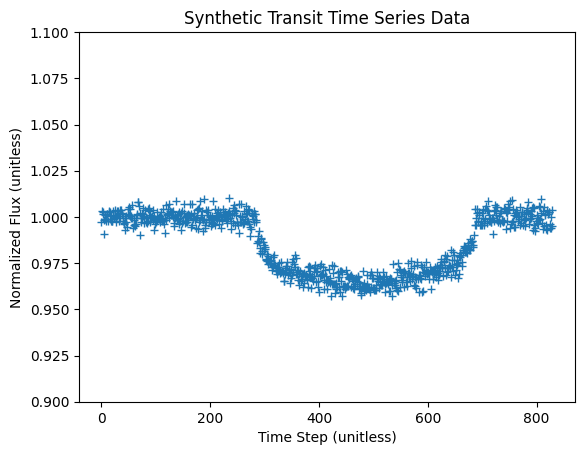

In [441]:
y = generate()
print(y.shape)
plt.plot(y, '+')
plt.ylim(0.9, 1.1)
plt.title('Synthetic Transit Time Series Data')
plt.xlabel('Time Step (unitless)')
plt.ylabel('Normalized Flux (unitless)')

In [442]:
# parallelism!!!

import concurrent.futures

def generate_n(n):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    # Submit `generate` multiple times
    futures = [executor.submit(generate) for _ in range(n)]

    # Retrieve results as they are completed
    results = [future.result() for future in concurrent.futures.as_completed(futures)]
  return results

def generate_n_dry(n):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    # Submit `generate` multiple times
    futures = [executor.submit(generate_dry) for _ in range(n)]

    # Retrieve results as they are completed
    results = [future.result() for future in concurrent.futures.as_completed(futures)]
  return results

In [722]:
np.random.seed(42)

count = 2**13

print(count)

8192


In [723]:
true_data = generate_n(count);
true_label = np.ones(count);
false_data = generate_n_dry(count);
false_label = np.zeros(count);
combined_data = true_data + false_data
combined_label = np.concatenate((true_label, false_label))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [727]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(combined_data, combined_label, test_size=0.5, random_state=42)

In [728]:
max_length = max(len(inner_array) for inner_array in combined_data)

print(max_length)

X_train_padded = np.array([np.pad(i, (0, max_length - len(i)), mode="constant", constant_values=0) for i in X_train])
X_val_padded = np.array([np.pad(i, (0, max_length - len(i)), mode="constant", constant_values=0) for i in X_val])

3138


In [729]:
X_train_shaped = X_train_padded.reshape(len(X_train_padded), max_length, 1)
X_val_shaped = X_val_padded.reshape(len(X_val_padded), max_length, 1)

(0.9, 1.1)

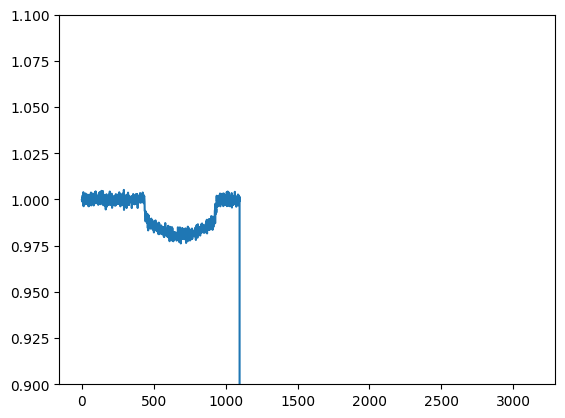

In [730]:
plt.plot(X_train_padded[220])
plt.ylim(0.9, 1.1)

# 0.3 Model Training



In [759]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Flatten, Dense, Dropout, MaxPooling1D, Bidirectional, GlobalAveragePooling1D, Input, BatchNormalization, Masking
from tensorflow.keras.regularizers import l2


def custom_cnn():
  model = Sequential([
    Input(shape=(None, 1)),
    Masking(mask_value=0),

    Conv1D(filters=64, kernel_size=6, activation='relu', padding='same'),
    MaxPooling1D(pool_size=8),

    Conv1D(filters=128, kernel_size=6, activation='relu', padding='same'),
    MaxPooling1D(pool_size=4),

    Conv1D(filters=256, kernel_size=6, activation='relu', padding='same'),
    MaxPooling1D(pool_size=4),

    GlobalAveragePooling1D(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = custom_cnn()

In [ ]:
model.summary()

In [761]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

history = model.fit(
    X_train_padded, y_train,
    epochs=64,
    batch_size=256,
    validation_data=(X_val_padded, y_val),
    callbacks=callbacks
)

Epoch 1/64
32/32 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.5104
Epoch 1: val_loss improved from inf to 0.70223, saving model to best_model.h5
32/32 [==============================] - 9s 256ms/step - loss: 0.7065 - accuracy: 0.5104 - val_loss: 0.7022 - val_accuracy: 0.5057
Epoch 2/64
32/32 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.5474
Epoch 2: val_loss improved from 0.70223 to 0.69203, saving model to best_model.h5
32/32 [==============================] - 8s 242ms/step - loss: 0.6987 - accuracy: 0.5474 - val_loss: 0.6920 - val_accuracy: 0.5713
Epoch 3/64
32/32 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.5934
Epoch 3: val_loss improved from 0.69203 to 0.64951, saving model to best_model.h5
32/32 [==============================] - 8s 245ms/step - loss: 0.6737 - accuracy: 0.5934 - val_loss: 0.6495 - val_accuracy: 0.5909
Epoch 4/64
32/32 [==============================] - ETA: 0s - loss: 0.6408 - accura

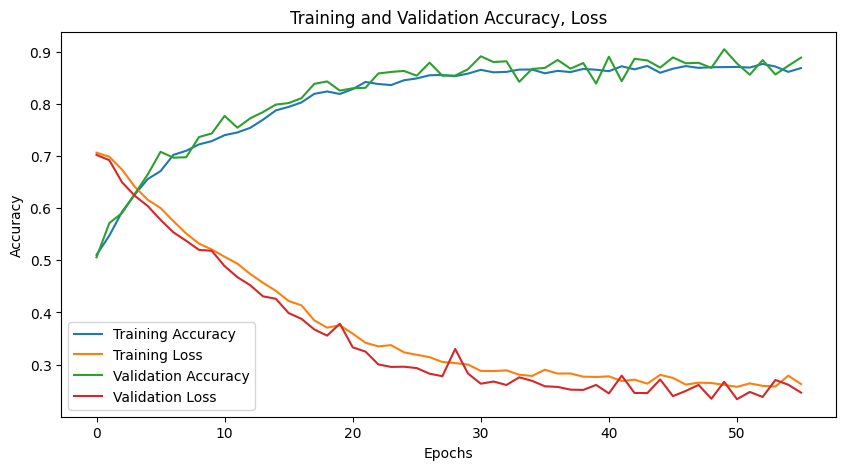

In [762]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(train_loss, label='Training Loss')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Accuracy, Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 1.1. Preprocessing

FITS files are just generic data containers. For time series data they are structured as follows:

* fits[0] = header
* fits[1] = timestamp of data
* fits[2...n] = data points

Want data in the following form:


```
[wavelength, time] = process(fits)
```



Where wavelength is specified in increments [2048] as every datapoint uses the same lens and time is dependent on the fits file inputted.

In [532]:
def process(url):
  sample = fits.open("/content/drive/MyDrive/SML 312/Final/{}".format(url))
  num_times = min(sample[1].data["integration_number"].shape[0], max_length)
  size = sample[2].data["FLUX"].shape[0]

  data = [[sample[i + 2].data["FLUX"][j] for i in range(num_times)] for j in range(size)]

  data = [i / max(i) for i in data]
  return np.array(data)

# unit: MJD (modified julian days)
def duration(times):
  return np.max(times) - np.min(times)

def predict(samp, mod):
  data = []
  for i in samp:
    data.append(mod.predict(i.reshape(1, -1, 1)))
  return [i[0][0] for i in data]

# 1.2 Prediction

Here's the fun part.

In [678]:
test_data = generate_n(1024)
test_label = np.ones(1024)
test_data_dry = generate_n_dry(1024)
test_label_dry = np.zeros(1024)

test_comb_data = test_data + test_data_dry
test_comb_label = np.concatenate((test_label, test_label_dry))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [763]:
test_comb_data_padded = [i[0:max_length] if len(i) > max_length else i for i in test_comb_data]

test_comb_data_padded = np.array([np.pad(i, (0, max_length - len(i)), mode="constant", constant_values=0) for i in test_comb_data_padded])

1/1 [==============================] - 0s 25ms/step
[[1.517579e-07]]


(0.9, 1.1)

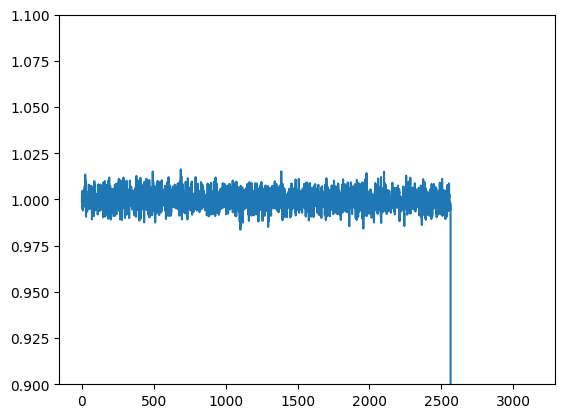

In [823]:
y = generate_dry()
y = np.pad(y, (0, max_length - len(y)), mode="constant", constant_values=0)
check_predict = model.predict(y.reshape(1, -1, 1))
print(check_predict)

plt.plot(y)
plt.ylim(0.9, 1.1)

256/256 [==============================] - 2s 9ms/step


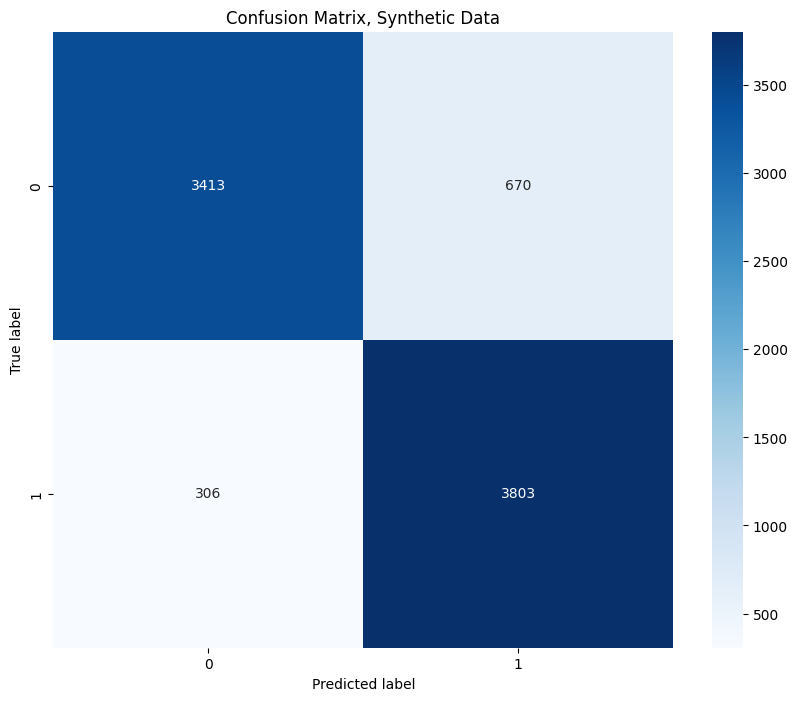

In [765]:
check_predict = model.predict(X_train_shaped)
check_predict_label = [np.round(i) for i in check_predict]

cmt = confusion_matrix(y_train, check_predict_label)

plt.figure(figsize=(10,8))
sns.heatmap(cmt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix, Training Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

256/256 [==============================] - 3s 10ms/step
[array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=f

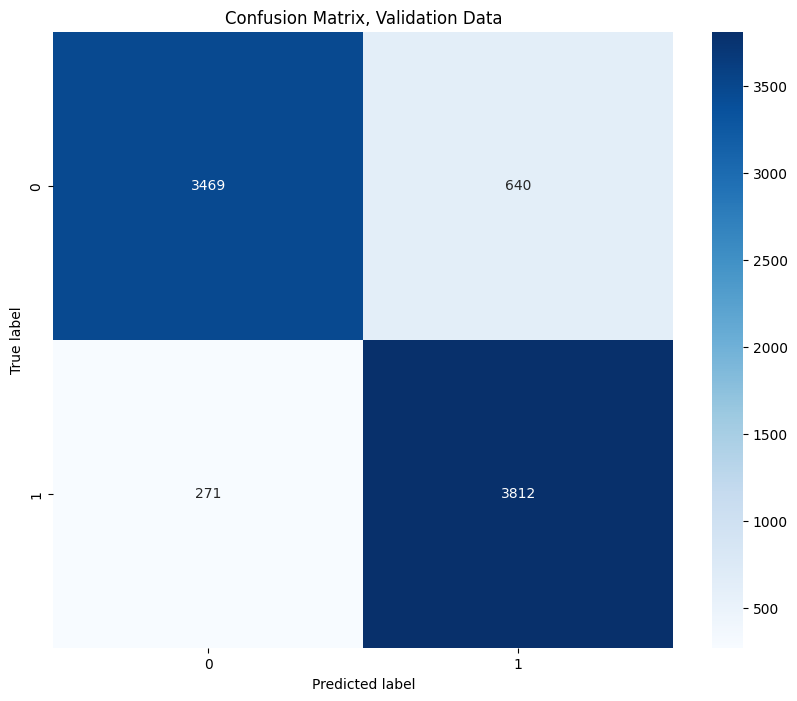

In [766]:
val_predict = model.predict(X_val_shaped)
val_predict_label = [np.round(i) for i in val_predict]

cmv = confusion_matrix(y_val, val_predict_label)

plt.figure(figsize=(10,8))
sns.heatmap(cmv, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix, Validation Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

64/64 [==============================] - 1s 9ms/step


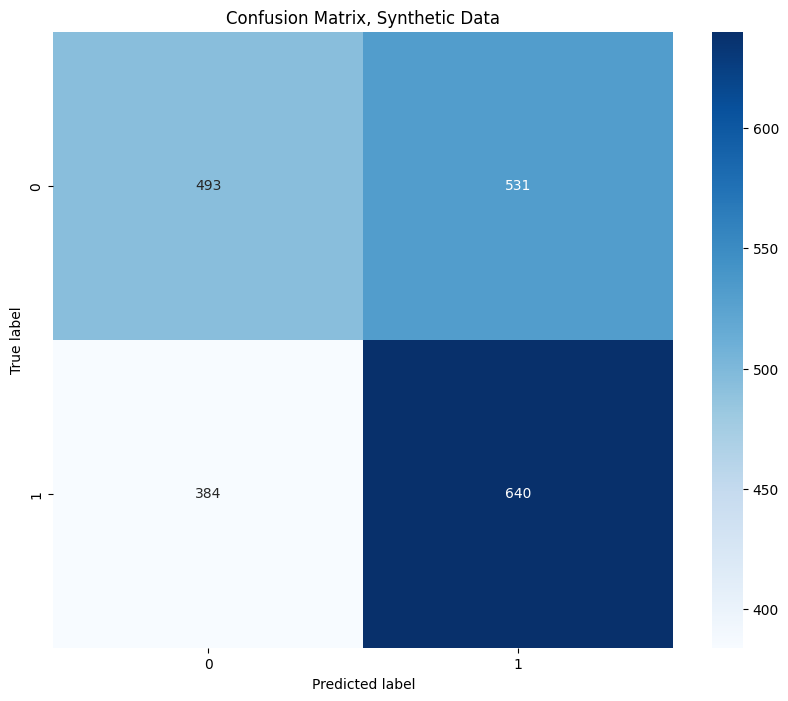

In [767]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

synth_predict = model.predict(test_comb_data_padded.reshape(len(test_comb_data_padded), max_length, 1))
synth_predict_label = [np.round(i) for i in synth_predict]

cm = confusion_matrix(test_comb_label, synth_predict_label)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix, Synthetic Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [474]:
wasp80 = process("wasp80.fits")
wasp39 = process("wasp39.fits")
hatp14 = process("hatp14.fits")
no55cnc = process("no-55cnc.fits")
notrappist = process("no-trappist.fits")
nowasp17b = process("no-wasp17b.fits")
nohd149026 = process("no-hd149026.fits")

In [475]:
wasp107 = process("wasp107.fits")

In [476]:
# I probably should've done this in process() but
# oh well

wasp80 = np.array(wasp80)
wasp39 = np.array(wasp39)
wasp107 = np.array(wasp107)
hatp14 = np.array(hatp14)

no55cnc = np.array(no55cnc)
notrappist = np.array(notrappist)
nowasp17b = np.array(nowasp17b)
nohd149026 = np.array(nohd149026)

In [826]:
def derat(data):
  r = []
  for i in data:
    if np.isnan(i[0]):
      continue
    else:
      r.append(i)
  return np.array(r)

wasp80a = derat(wasp80)
wasp39a = derat(wasp39)
wasp107a = derat(wasp107)
hatp14a = derat(hatp14)

no55cnca = derat(no55cnc)
notrappista = derat(notrappist)
nowasp17ba = derat(nowasp17b)
nohd149026a = derat(nohd149026)

(0.0, 1.1)

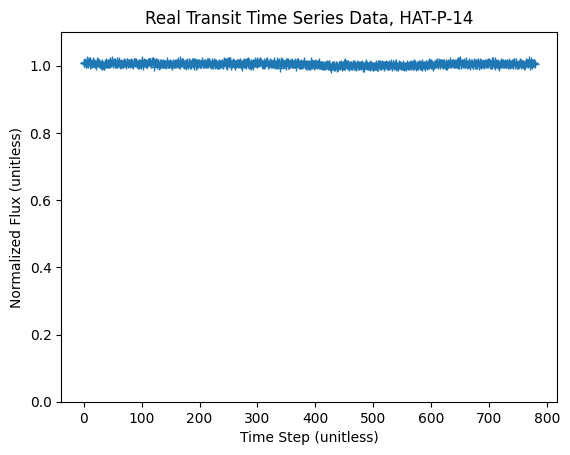

In [847]:
plt.plot(hatp14a[200], '+')
plt.title('Real Transit Time Series Data, HAT-P-14')
plt.ylabel('Normalized Flux (unitless)')
plt.xlabel('Time Step (unitless)')
plt.ylim(0, 1.1)

In [827]:
# background mean normalize
def bmn(data):
  data = np.array(data)
  threshold = data.mean() - 0.5 * data.std()
  background_data = data[data > threshold]

  background_mean = background_data.mean()
  return data / background_mean

wasp80a = bmn(wasp80a)
wasp39a = bmn(wasp39a)
wasp107a = bmn(wasp107a)
hatp14a = bmn(hatp14a)

In [828]:
true1 = [np.pad(i, (0, max_length - len(i)), mode='constant', constant_values=0) for i in wasp80a]
true2 = [np.pad(i, (0, max_length - len(i)), mode='constant', constant_values=0) for i in wasp39a]
true3 = [np.pad(i, (0, max_length - len(i)), mode='constant', constant_values=0) for i in wasp107a]
true4 = [np.pad(i, (0, max_length - len(i)), mode='constant', constant_values=0) for i in hatp14a]

false1 = [np.pad(i, (0, max_length - len(i)), mode='constant', constant_values=0) for i in no55cnca]
false2 = [np.pad(i, (0, max_length - len(i)), mode='constant', constant_values=0) for i in notrappista]
false3 = [np.pad(i, (0, max_length - len(i)), mode='constant', constant_values=0) for i in nowasp17ba]
false4 = [np.pad(i, (0, max_length - len(i)), mode='constant', constant_values=0) for i in nohd149026a]

In [829]:
def random128(a):
  a = np.array(a)
  i = np.random.choice(len(a), size=128, replace=False)
  return a[i, :]

np.random.seed(69)

real_data = np.concatenate((random128(true1), random128(true2), random128(true3), random128(true4)))
real_label = np.ones(512)
real_data_dry = np.concatenate((random128(false1), random128(false2), random128(false3), random128(false4)))
real_label_dry = np.zeros(512)

real_comb_data = np.concatenate((real_data, real_data_dry))
real_comb_label = np.concatenate((real_label, real_label_dry))

32/32 [==============================] - 0s 10ms/step


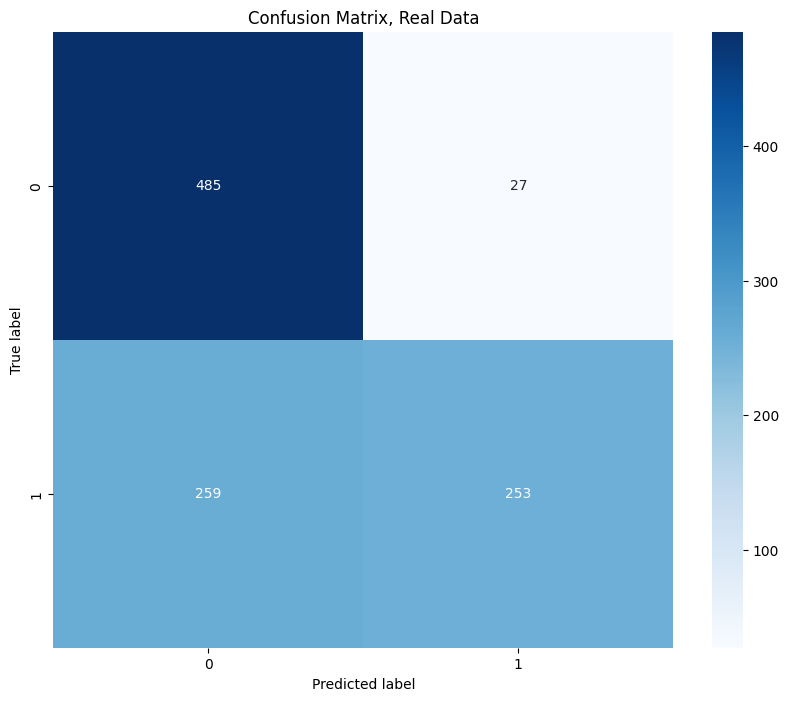

In [830]:
real_predict = model.predict(real_comb_data.reshape(len(real_comb_data), max_length, 1))
real_predict_label = [np.round(i) for i in real_predict]

cm2 = confusion_matrix(real_comb_label, real_predict_label)

plt.figure(figsize=(10,8))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix, Real Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [262]:
mistake_indices = np.where(real_predict_label != real_comb_label)[0]

mistake_data = real_comb_data[mistake_indices]
mistake_label = real_comb_label[mistake_indices]

1.0


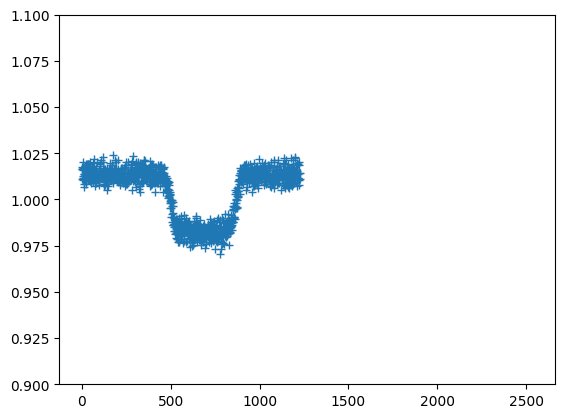

In [265]:
index = 100

plt.plot(mistake_data[index], '+')
plt.ylim(0.9, 1.1)
print(mistake_label[index])

In [839]:
real_predict_label[2]

array([1.], dtype=float32)

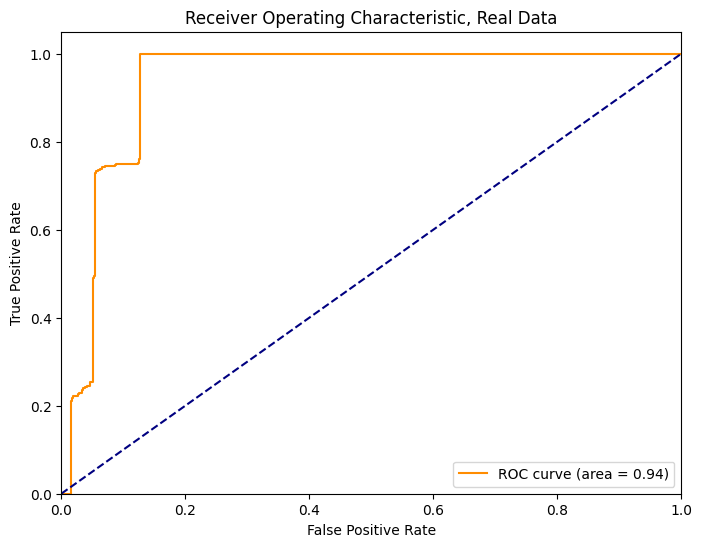

In [841]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(real_comb_label, real_predict)
auc = roc_auc_score(real_comb_label, real_predict)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, Real Data')
plt.legend(loc="lower right")
plt.show()